In [1]:
import os
from concurrent.futures import ProcessPoolExecutor
from pathlib import Path

import matplotlib.pyplot as plt
import torch

from lhotse import CutSet, Fbank, LilcomFilesWriter
from lhotse.augmentation import SoxEffectTransform, RandomValue, pitch, reverb, speed
from lhotse.dataset import K2SpeechRecognitionDataset
from lhotse.dataset.sampling import SingleCutSampler
from lhotse.recipes.librispeech import download_librispeech, prepare_librispeech

# Settings for paths

In [2]:
root_dir = Path('data')
corpus_dir = root_dir / 'LibriSpeech'
output_dir = root_dir / 'librispeech_nb'

# Select data parts

In [3]:
dataset_parts = ('dev-clean', 'test-clean', 'train-clean-100')

# Download and untar

In [4]:
download_librispeech(root_dir, dataset_parts)

# Prepare audio and supervision manifests

In [4]:
num_jobs = os.cpu_count()

In [5]:
librispeech_manifests = prepare_librispeech(corpus_dir, dataset_parts, output_dir, num_jobs=num_jobs)

# [Optional] Data augmentation

In [6]:
use_data_augmentation = False
augment_fn = SoxEffectTransform(effects=[
   ['reverb', 50, 50, RandomValue(0, 100)],
   ['speed', RandomValue(0.9, 1.1)],
   ['rate', 16000],
]) if use_data_augmentation else None

# Extract features

In [7]:
for partition, manifests in librispeech_manifests.items():
    manifest_path = output_dir / f'cuts_{partition}.json.gz'
    if manifest_path.is_file():
        librispeech_manifests[partition] = CutSet.from_json(manifest_path)
    else:
        with ProcessPoolExecutor(num_jobs) as ex:
            cut_set = CutSet.from_manifests(
                recordings=manifests['recordings'],
                supervisions=manifests['supervisions']
            ).compute_and_store_features(
                extractor=Fbank(),
                storage_path=f'{output_dir}/feats_{partition}',
                storage_type=LilcomFilesWriter,
                augment_fn=augment_fn,
                executor=ex
            ).pad()
        librispeech_manifests[partition]['cuts'] = cut_set
        cut_set.to_json(manifest_path)

# Make PyTorch Dataset

In [8]:
cutset_dev = librispeech_manifests['dev-clean']
cutset_train = librispeech_manifests['train-clean-100']

In [9]:
dataset_dev = K2SpeechRecognitionDataset(cutset_dev)
dataset_train = K2SpeechRecognitionDataset(cutset_train)

# Illustration of an example

In [10]:
sampler = SingleCutSampler(cutset_dev, shuffle=False, max_samples=16)
cut_ids = next(iter(sampler))
sample = dataset_dev[cut_ids]

Transcript: HAD LAID BEFORE HER A PAIR OF ALTERNATIVES NOW OF COURSE YOU'RE COMPLETELY YOUR OWN MISTRESS AND ARE AS FREE AS THE BIRD ON THE BOUGH I DON'T MEAN YOU WERE NOT SO BEFORE BUT YOU'RE AT PRESENT ON A DIFFERENT FOOTING
Supervisions mask: tensor([1., 1., 1.,  ..., 0., 0., 0.])
Feature matrix:


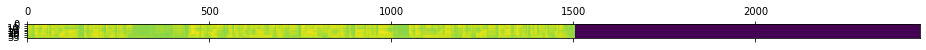

In [11]:
print('Transcript:', sample['supervisions']['text'][0])
print('Supervisions start frame:', int(sample['supervisions']['start_frame'][0]))
print('Supervisions frame number:', int(sample['supervisions']['num_frames'][0]))
print('Feature matrix:')
plt.matshow(sample['inputs'].reshape([sample['inputs'].shape[1], -1]).transpose(0, 1).flip(0));

# Make PyTorch Dataloader

In [12]:
train_dl = torch.utils.data.DataLoader(dataset_train, batch_size=32, shuffle=True)
dev_dl = torch.utils.data.DataLoader(dataset_dev, batch_size=None, sampler=sampler)

In [13]:
for batch in dev_dl:
    for key, value in batch.items():
        print(key, '- shape or length:', end=' ')
        if isinstance(value, torch.Tensor):
            print(value.shape)
        else:
            print(len(value))
    break

inputs - shape or length: torch.Size([1, 3170, 40])
supervisions - shape or length: 4
